In [1]:
import numpy as np # linear algebra
import os, sys
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import cv2
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

Using TensorFlow backend.


In [2]:
folder = 'coins/br-coins/circles'

image_width = 120
image_height = 120
channels = 3

train_files = []
i=0
for coin in [5, 10, 25, 50, 100]:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(coin)) if os.path.isfile(os.path.join(folder + '/' + str(coin), f))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

i = 0
for coin in [5, 10, 25, 50, 100]:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(coin)) if os.path.isfile(os.path.join(folder + '/' + str(coin), f))]
    for _file in onlyfiles:
        #img = load_img(folder + '/' +  str(coin) + '/' + _file)  # this is a PIL image
        #img.thumbnail((image_width, image_height))
        # Convert to Numpy Array
        #x = img_to_array(img)
        # open with opencv
        x = np.array(cv2.imread(folder + '/' +  str(coin) + '/' + _file))
        #x = x.reshape((3, 120, 160))
        # Normalize
        #x = (x - 128.0) / 128.0

        dataset[i] = x
        mapping = {5: 0, 10: 1, 25: 2, 50: 3, 100: 4}
        y_dataset.append(mapping[coin])
        i += 1
        if i % 250 == 0:
            print("%d images to array" % i)
print("All images to array!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
All images to array!


In [3]:
dataset[0].shape

(120, 120, 3)

In [4]:
# normalize
dataset = dataset.astype('float32')
dataset /= 255

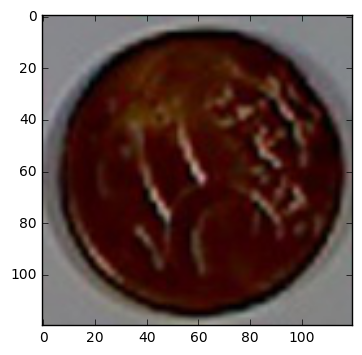

In [5]:
pixels = np.array(dataset[0], dtype='float32')
#pixels = pixels.reshape((64, 64, 3))
plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB))
plt.show()
#print(scaled_labels[0])

In [6]:
from keras.utils import np_utils

# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = np_utils.to_categorical(y_dataset, n_classes)

5


In [7]:
# splitting into training and test
from sklearn.cross_validation import train_test_split

#Splitting 
X_train, X_test, y_train, y_test = train_test_split(dataset, y_dataset_, test_size=0.2)
print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 2428, Test set size: 607


/home/rodrigoazs/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# Data augmentation

datagen = ImageDataGenerator(
        rotation_range=90,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(X_train)

In [9]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

sess = tf.Session()
with tf.device('/cpu:0'):
    classifier = Sequential()
    classifier.add(Convolution2D(32, 3, 3, input_shape = (120, 120, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(output_dim = 128, activation='relu'))
    classifier.add(Dense(output_dim = n_classes, activation=tf.nn.softmax))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

    batch_size = 128
    n_epoch = 20

    #classifier.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_data=(X_test, Y_test))
    
    classifier.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                    samples_per_epoch=len(X_train),  
                    nb_epoch=n_epoch, 
                    validation_data=(X_test, y_test),
                    nb_val_samples=len(X_test),
                    verbose=1)

/home/rodrigoazs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(120, 120,...)`
/home/rodrigoazs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=128, activation="relu")`
/home/rodrigoazs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=5, activation=<function ...)`
/home/rodrigoazs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` argume

Epoch 1/20
18/18 [==============================] - 35s 2s/step - loss: 2.7375 - acc: 0.2943 - val_loss: 1.0165 - val_acc: 0.6310
Epoch 2/20
18/18 [==============================] - 36s 2s/step - loss: 0.7058 - acc: 0.7443 - val_loss: 0.6591 - val_acc: 0.7364
Epoch 3/20
18/18 [==============================] - 37s 2s/step - loss: 0.4957 - acc: 0.8013 - val_loss: 0.5626 - val_acc: 0.7809
Epoch 4/20
18/18 [==============================] - 34s 2s/step - loss: 0.4429 - acc: 0.8216 - val_loss: 0.4619 - val_acc: 0.8155
Epoch 5/20
18/18 [==============================] - 34s 2s/step - loss: 0.3633 - acc: 0.8541 - val_loss: 0.3990 - val_acc: 0.8484
Epoch 6/20
18/18 [==============================] - 35s 2s/step - loss: 0.3389 - acc: 0.8735 - val_loss: 0.3901 - val_acc: 0.8188
Epoch 7/20
18/18 [==============================] - 40s 2s/step - loss: 0.2920 - acc: 0.8887 - val_loss: 0.3317 - val_acc: 0.8600
Epoch 8/20
18/18 [==============================] - 35s 2s/step - loss: 0.3021 - acc: 0.88

In [15]:
# saving model
classifier.save_weights('coins_weights.h5', overwrite=True)
#classifier.save('coins.h5')
from keras.models import model_from_yaml

# serialize model to YAML
model_yaml = classifier.to_yaml()
with open("coins.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
#model.save_weights("model.h5")

In [11]:
preds = classifier.predict(X_test)

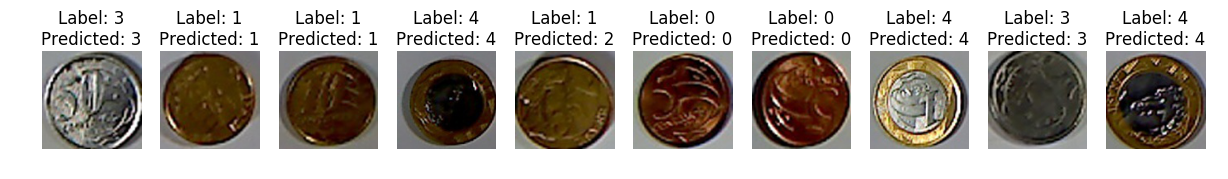

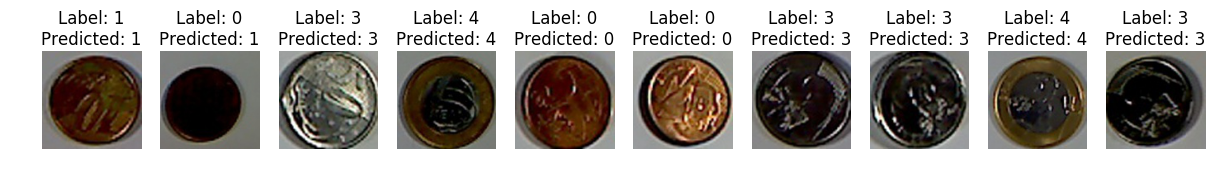

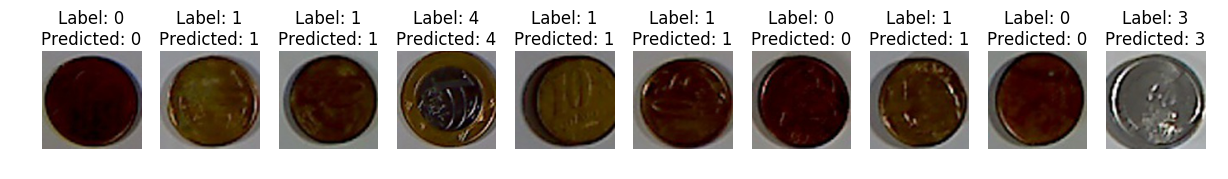

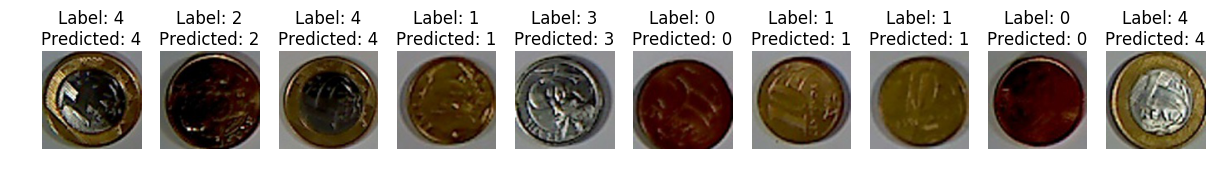

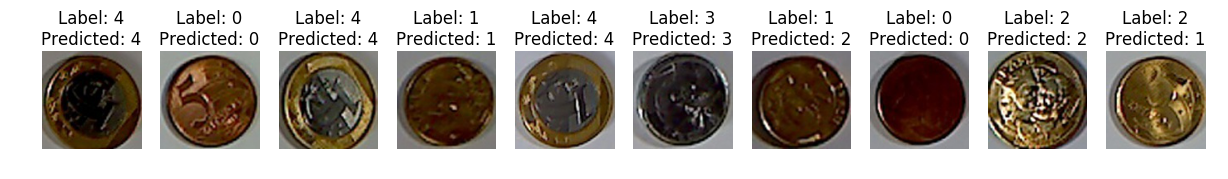

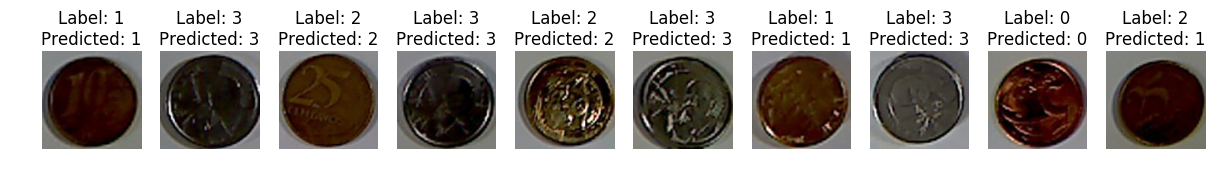

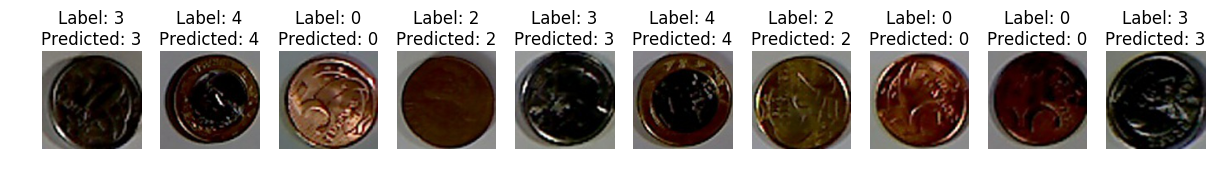

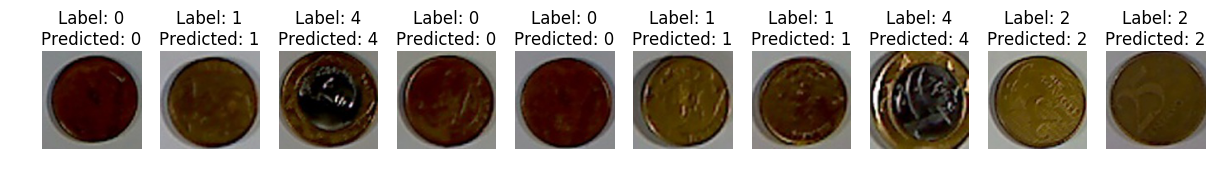

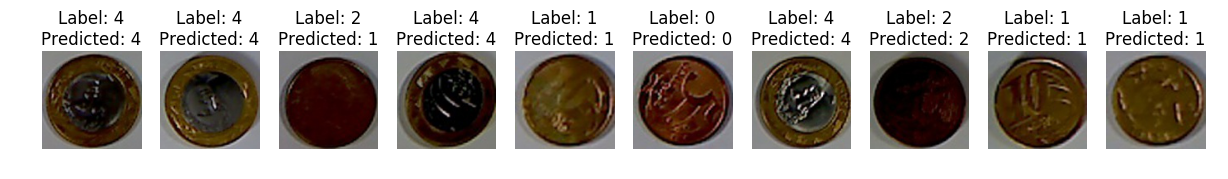

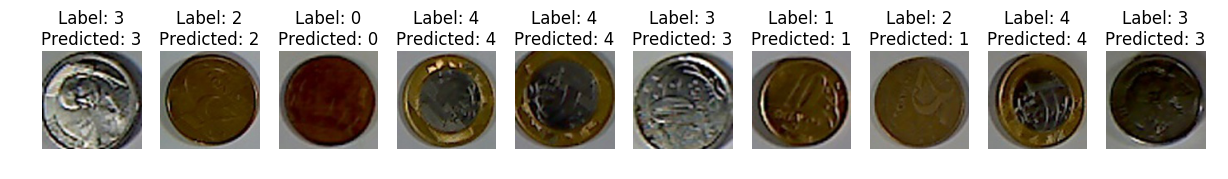

In [12]:
n = 10
for t in range(10):
    plt.figure(figsize=(15,15))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Label: {}\nPredicted: {}'.format(np.argmax(y_test[i]), np.argmax(preds[i])))
        plt.axis('off')
    plt.show()

In [13]:
import matplotlib.pyplot as plt

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

Confusion matrix, without normalization
[[112   2   1   0   0]
 [  1 108  19   1   0]
 [  1  15  99   1   0]
 [  0   0   0 126   0]
 [  0   0   0   0 121]]


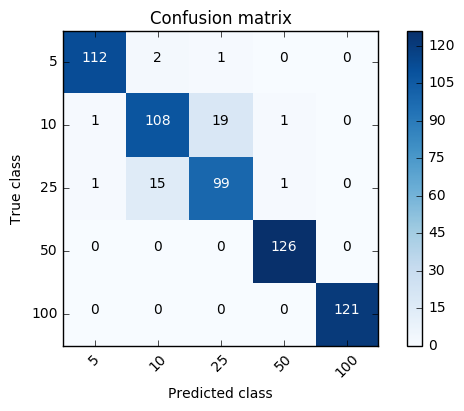

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Plot non-normalized confusion matrix
#y_test_ = np.apply_along_axis(np.argmax, 1, y_test)
#preds_ = np.apply_along_axis(np.argmax, 1, preds)
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plt.figure()
plot_confusion_matrix(cm, classes=['5', '10', '25', '50', '100'], title='Confusion matrix')
plt.show()

In [16]:
def extract_coins(img, to_size=100):
    """
    Find coins on the image and return array
    with all coins in (to_size, to_size) frame 
    
    return (n, to_size, to_size, 3) array
           array of radiuses fo coins
    n - number of coins
    color map: BGR
    """
    # Convert to b&w
    cimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find circles on the image
    circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT, 2, 60, param1=300, param2=30, minRadius=30, maxRadius=50)
    
    # Convert to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define color range for masking
    lower = np.array([0,0,0])
    upper = np.array([255,255,90])
    # Apply the mask
    mask = cv2.blur(cv2.inRange(hsv, lower, upper), (8, 8))
    
    
    frames = []
    # If circles were not found
    if circles is None:
        return None, None
    
    for circle in circles[0]:
        
        center_x = int(circle[0])
        center_y = int(circle[1])
        
        # If center of coin lays in masked coin range
        if not mask[center_y, center_x]:
            continue
        
        # increase radius by C
        # circle detector tends to decrease radius
        radius = circle[2] + 3
        
        # Coordinates of upper left corner of square
        x = int(center_x - radius)
        y = int(center_y - radius)
        
        # As radius was increased the coordinates
        # could go out of bounds
        if y < 0:
            y = 0
        if x < 0:
            x = 0
        
        # Scale coins to the same size
        resized = cv2.resize(img[y: int(y + 2 * radius), x: int(x + 2 * radius)], 
                             (to_size, to_size), 
                             interpolation = cv2.INTER_CUBIC)
        #resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        frames.append((np.array(resized), radius, (x, y)))

    return frames

In [32]:
# load regression samples
folder = 'coins/br-coins/regression_sample'

train_files = []
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
for _file in onlyfiles:
    train_files.append(_file)
    
train_files = [train_files[612]]
        
image_width = 640
image_height = 480
channels = 3

image_list = []
label_list = []

for file in train_files:
    image_list.append(np.array(cv2.imread(folder + '/' + file)))
    label_list.append(int(file.split('_')[0]))

images = np.array(image_list)
labels = np.array(label_list)

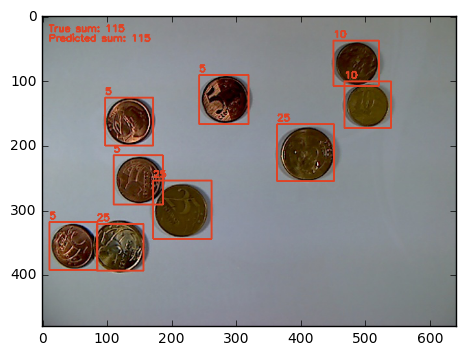

In [33]:
mapping = {0: '5', 1: '10', 2: '25', 3: '50', 4: '100'}

final_images = []
predicted = []
for image, true_label in zip(images, labels):
    coins = extract_coins(image, to_size=120)
    coins_sum = 0
    for coin in coins:
        # draw a bounding box rectangle and label on the image
        img_coin = coin[0]
        img_coin = img_coin.astype('float32')
        img_coin /= 255
        pred = classifier.predict(np.array([img_coin]))
        label = mapping[np.argmax(pred)]
        coins_sum += int(label)
        #confidence = np.max(pred)
        (x, y) = coin[2]
        radius = int(coin[1])
        image = cv2.rectangle(image, (x, y), (x + 2*radius, y + 2*radius), (37, 67, 224), 2)
        #text = "{}: {:.4f}".format(label, confidence)
        text = "{}".format(label)
        image = cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (37, 67, 224), 2)
    #pixels = np.array(img, dtype='int')
    image = cv2.putText(image, 'True sum: {}'.format(str(true_label)), (10, 30 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (37, 67, 224), 2)
    image = cv2.putText(image, 'Predicted sum: {}'.format(str(coins_sum)), (10, 45 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (37, 67, 224), 2)
    final_images.append(image)
    predicted.append(coins_sum)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()